### Carregando as Bibliotecas

In [2]:
! pip install lightgbm
! pip install xgboost

In [ ]:
import plotly_express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import scipy
import seaborn as sns
import statsmodels
import statsmodels.stats.api as sms

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
# parâmetros dos gráficos para o arquivo
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
%matplotlib inline
plt.rcParams.update(params)

### Arquivo_EUA

In [ ]:
df= pd.read_excel(r'dataset_mestre_EUA.xlsx')

In [ ]:
df=df.fillna(0.001)

In [ ]:
df.head(2)

In [ ]:
# colunas - novos nomes
df = df.rename(columns = {"População_Estado_EUA":"pope", "PIB_Estado_EUA (US$ Bi)":"pibe","Area_Estado_EUA(territ_seco_km2)":"areae","Total_Eletricidade_EUA (MW.h)":"GWe"}, inplace = False)

In [ ]:
df.head(2)

### Definição de Metadados & Padronização

In [ ]:
df['pibe_capita'] = df['pibe']/df['pope']
df['pibe_areae'] = df['pibe']/df['areae']
df['pibe_GWe'] = df['pibe']/df['GWe']
df['pope_areae'] = df['pope']/df['areae']
df['GWe_pope'] = df['GWe']/df['pope']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dfz = scaler.fit_transform(df)
dfz = pd.DataFrame(dfz)

In [14]:
dfe=dfz[["State",'pibe_capita_n','pibe_areae_n','pope_areae_n','pibe_GWe_n',
         'GWe_pope_n','solar_e_n','eole_n','bioSe_n','geoe_n','hyde_n']]

C:\Users\aferr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\aferr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\aferr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [15]:
# Preparação dos arquivos de entrada (X) e saída (y)
X = dfe.drop(columns=['solar_e_n','eole_n','bioSe_n','geoe_n','hyde_n','State'])
ysol = dfe.loc[:,'solar_e_n']
yeol = dfe.loc[:,'eole_n']
ybio = dfe.loc[:,'bioSe_n']
ygeo = dfe.loc[:,'geoe_n']
yhyd = dfe.loc[:,'hyde_n']

### Segundo caso - Eólico

In [28]:
# Divisão entre arquivos de treino e teste, com corte em 30%
X_train, X_test, y_train, y_test = train_test_split(X,yeol,test_size =0.3, random_state=1234)

In [29]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=100)
model.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

<AxesSubplot:>

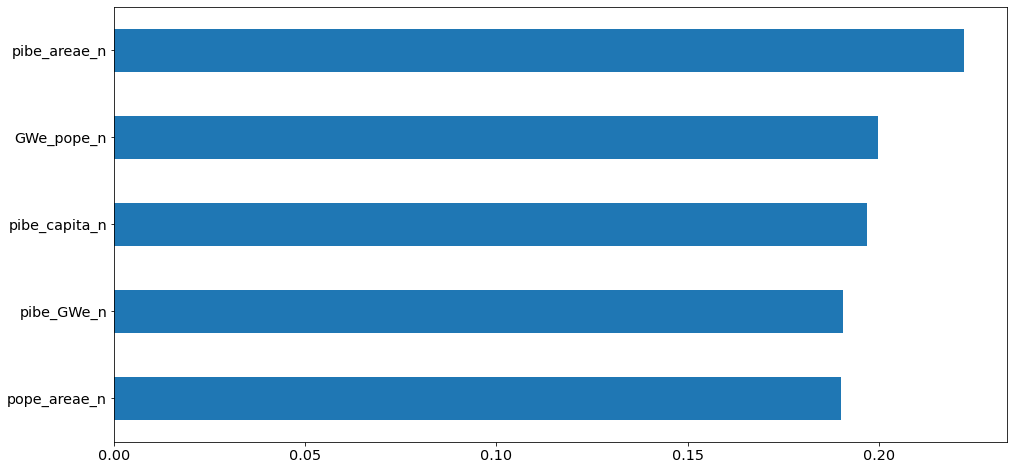

In [30]:
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(10).sort_values().plot.barh())

### Algoritmo Referência = Random Forest

In [31]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [32]:
params_grid= {'n_estimators':[2,3,4,5,6,7,8,9,10],
              "max_features":['auto'],
              'max_depth':[10,20,30],
              'max_leaf_nodes':[2,3,4,5],
              'min_samples_leaf':[5,10,15],
              'min_samples_split':[3,6,9,12,15,18,21]}
random_rf = RandomizedSearchCV(estimator = rf,cv=10,param_distributions=params_grid,n_iter=100,verbose=2,n_jobs=-1)
random_rf.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.6s finished
C:\Users\aferr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st...


In [33]:
random_rf.best_params_

{'n_estimators': 2,
 'min_samples_split': 18,
 'min_samples_leaf': 5,
 'max_leaf_nodes': 3,
 'max_features': 'auto',
 'max_depth': 10}

In [34]:
m_rf=RandomForestRegressor(n_estimators= 2,
 min_samples_split = 18,
 min_samples_leaf = 5,
 max_leaf_nodes = 3,
 max_features ='auto',
 max_depth = 10)

In [35]:
yrf = m_rf.fit(X_train,y_train)
print(yrf)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=3,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=18,
                      min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)


In [36]:
y_rf= yrf.predict(X_test)

### Avaliação dos Erros_Eolico

In [37]:
# https://medium.com/turing-talks/como-avaliar-seu-modelo-de-regress%C3%A3o-c2c8d73dab96#:~:text=Erro%20Quadr%C3%A1tico%20M%C3%A9dio%20(MSE)&text=Em%20outras%20palavras%2C%20pega%2Dse,esse%20n%C3%BAmero%2C%20pior%20o%20modelo.

In [38]:
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error # MSE
# RMSE = mean_squared_error(y_test,y_pred,squared=False) 
from sklearn.metrics import mean_absolute_error
import numpy as np
# MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
from sklearn.metrics import mean_squared_log_error

In [39]:
c=np.mean(y_train)
print(round(c,3))

0.125


In [40]:
R2 = r2_score(y_test,y_rf)
mse_rf = mean_squared_error(y_test, y_rf)
rmse_rf = mse_rf**0.5
mae_rf =  mean_absolute_error(y_test, y_rf)
# msle_rf = mean_squared_log_error(y_test,y_rf)
print('R2 =', round(R2,3))
print('MSE =', round(mse_rf,3))
print('RMSE =', round(rmse_rf,3))
print('MAE = ', round(mae_rf,3))
# print('MSLE =', round(msle_rf,3))

R2 = -0.245
MSE = 0.575
RMSE = 0.758
MAE =  0.55


In [41]:
# R2 ajustado -- ponderação entre os fatores mais relevantes
def adjusted_r2(y_test, y_rf,X_train):
    from sklearn.metrics import r2_score
    adj_r2 = (1 - ((1 - r2_score(y_test, y_rf)) * (len(y_test) - 1)) / 
          (len(y_test) - X_train.shape[1] - 1))
    return adj_r2
a= round(adjusted_r2(y_test,y_rf,X_train),3)
print(a)

-0.868


In [42]:
errop2= (y_test - y_rf)*100/y_test
# em porcentagem
media = round(np.mean(errop2),1)
print(media)
desvio = round(np.std(errop2),1)
print(desvio)

409.5
1258.8


In [43]:
a = np.mean(y_train)
print(round(a,3))

0.125


In [44]:
# Modelo de comparação simples - array com o valor médio de y_train
a = [0.125]*16
a = np.array(a)

In [45]:
# novo erro: modelo simples, com a média do conjunto treino
mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_rf = mse_rf/mse_m
print(round(mse_m,3), round(mse_rf,3))
print(round(r_rf,3))

0.62 0.575
0.927


### Uso inicial dos algoritmos GBoosting

### Otimização de parâmetros

In [46]:
# Light & XG Boosting
params= {
    'booster': ["gbtree","gblinear",'dart'],
    'learning rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max depth': [3,4,5,8,10,11,12],
    'min_child_weigth': [1,3,5,7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.6]
}

In [47]:
# Gradient Boosting
params0= {
    'min_samples_split': [300,400,500],
    'min_samples_leaf': [30,40,50],
    'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [5,6,7,8],
    'subsample': [0.6,0.7,0.8],
    'learning_rate' : [0.09, 0.1, 0.15]
}

In [48]:
# Adaptative Boosting
params1= {
    'n_estimators': [30,40,50],
    'learning_rate' : [0.09, 0.1, 0.15]
}

In [49]:
# GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train, y_train)
import lightgbm as lgb
lgb = lgb.LGBMRegressor(learning_rate = 0.001, 
                              num_leaves = 65,  
                              n_estimators = 100)                       
lgb.fit(X_train, y_train)
 # XGBoost
import xgboost as xgb
xgb= xgb.XGBRegressor(learning_rate=0.001,
                            max_depth = 1, 
                            n_estimators = 100)
xgb.fit(X_train, y_train)
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
ada = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=1), n_estimators=100,
    learning_rate=0.001)
ada.fit(X_train, y_train)

print('*****************ClassifiersDone*****************')

*****************ClassifiersDone*****************


In [50]:
# Random Search & Cross Validation
random_search_gbr = RandomizedSearchCV(gbr,param_distributions=params0,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_lgb = RandomizedSearchCV(lgb,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_xgb = RandomizedSearchCV(xgb,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_ada = RandomizedSearchCV(ada,param_distributions=params1,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [51]:
random_search_gbr.fit(X_train, y_train)
random_search_lgb.fit(X_train, y_train)
random_search_xgb.fit(X_train, y_train)
random_search_ada.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\aferr\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    2.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[10:10:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { learning rate, max depth, min_child_weigth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    5.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.4s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                                                    max_depth=1,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=1,
                                                                                    min_samples_split=2,
                                                                                    min_weight_fraction_lea

In [52]:
from sklearn.model_selection import cross_val_score
score_gbr=cross_val_score(gbr,X,ysol,cv=10)
score_lgb=cross_val_score(lgb,X,ysol,cv=10)
score_xgb=cross_val_score(xgb,X,ysol,cv=10)
score_ada=cross_val_score(ada,X,ysol,cv=10)

### Gradient Boosting

In [53]:
print(random_search_gbr.best_estimator_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.09, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=40, min_samples_split=500,
                          min_weight_fraction_leaf=0.2, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.8, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)


In [65]:
m_gbr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.09, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=40, min_samples_split=400,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [66]:
m_gbr.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.09, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=40, min_samples_split=400,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [67]:
y_gbr = m_gbr.predict(X_test)

In [68]:
mse_gbr = round(mean_squared_error(y_test, y_gbr),3)
print(mse_gbr)

0.601


In [69]:
errop2= (y_test - y_gbr)*100/y_test
a = np.mean(errop2)
print(round(a,3))
# em porcentagem

4.852


In [70]:
R2 = r2_score(y_test,y_gbr)
mse_gbr = mean_squared_error(y_test, y_gbr)
rmse_gbr = mse_gbr**0.5
mae_gbr =  mean_absolute_error(y_test, y_gbr)
# msle_rf = mean_squared_log_error(y_test,y_rf)
print('R2 =', round(R2,3))
print('MSE =', round(mse_gbr,3))
print('RMSE =', round(rmse_gbr,3))
print('MAE = ', round(mae_gbr,3))
# print('MSLE =', round(msle_rf,3))

R2 = -0.303
MSE = 0.601
RMSE = 0.776
MAE =  0.689


In [71]:
def adjusted_r2(y_test, y_gbr,X_train):
    from sklearn.metrics import r2_score
    adj_r2 = (1 - ((1 - r2_score(y_test, y_gbr)) * (len(y_test) - 1)) / 
          (len(y_test) - X_train.shape[1] - 1))
    return adj_r2
a= round(adjusted_r2(y_test,y_gbr,X_train),3)
print(a)

-0.954


In [75]:
# Modelo de comparação simples - array com o valor médio de y_train
a = [0.125]*16

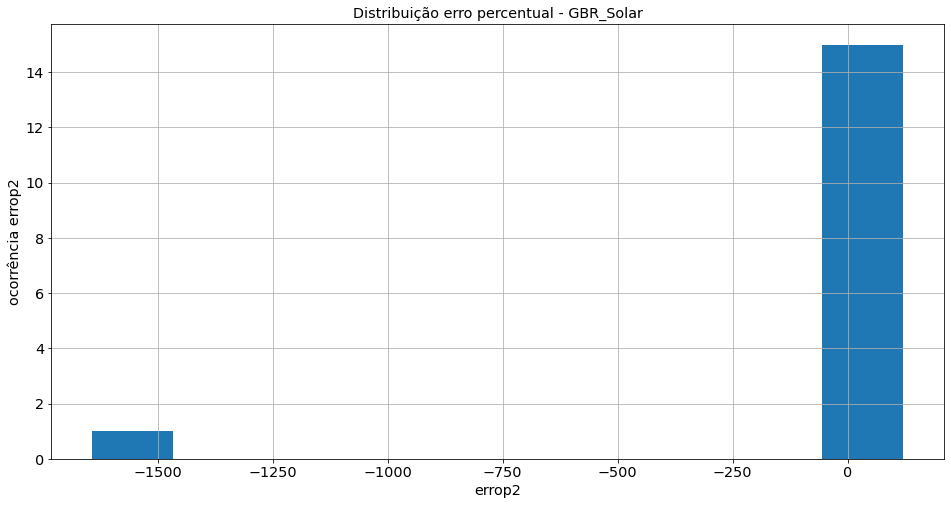

In [76]:
errop2.hist()
plt.title("Distribuição erro percentual - GBR_Solar")
plt.xlabel("errop2")
plt.ylabel("ocorrência errop2")
plt.show()

In [77]:
# novo erro: modelo simples, com a média do conjunto treino
mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_gbr = mse_gbr/mse_m
print(round(mse_m,3), round(mse_gbr,3))
print(round(r_gbr,3))

0.62 0.601
0.97


### Light Gradient Boosting

In [78]:
print(random_search_lgb.best_estimator_)

LGBMRegressor(booster='dart', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.6, gamma=0.2, importance_type='split',
              learning rate=0.3, learning_rate=0.001, max depth=4, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_child_weigth=7,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=65,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)


In [89]:
from lightgbm import LGBMRegressor
m_lgb = LGBMRegressor(booster='dart', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.5, gamma=0.2, importance_type='split',
              learning_rate=0.001, max_depth=4,
              min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=65,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [90]:
m_lgb.fit(X_train,y_train)

LGBMRegressor(booster='dart', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.5, gamma=0.2, importance_type='split',
              learning_rate=0.001, max_depth=4, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=65, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [91]:
y_lgb = m_lgb.predict(X_test)

In [92]:
mse_lgb = round(mean_squared_error(y_test, y_lgb),3)
print(mse_lgb)

0.62


In [93]:
errop2= (y_test - y_lgb)*100/y_test
# em porcentagem

In [94]:
a = [0.125]
a = a*16

In [95]:
# novo erro: modelo simples, com a média do conjunto treino
mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_lgb = mse_lgb/mse_m
print(round(mse_m,3), round(mse_lgb,3))
print(round(r_lgb,3))

0.62 0.62
1.0


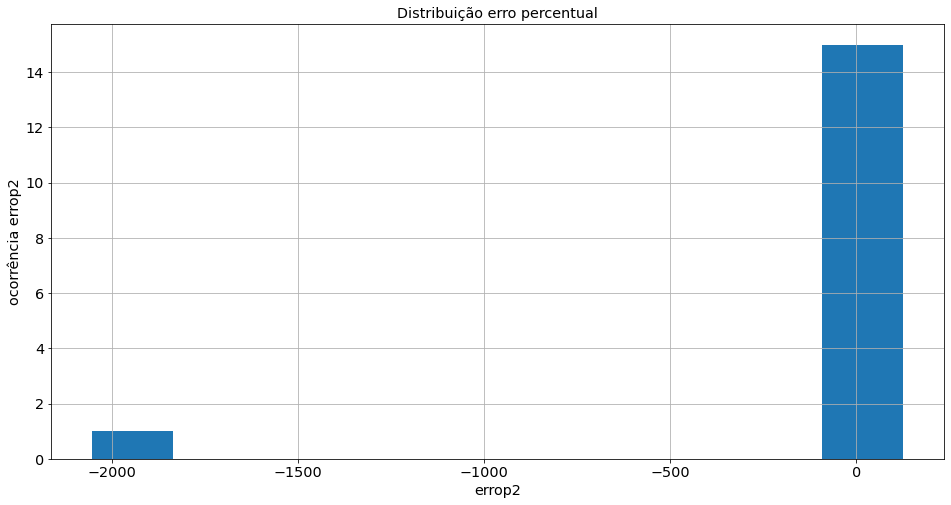

In [96]:
errop2.hist()
plt.title("Distribuição erro percentual")
plt.xlabel("errop2")
plt.ylabel("ocorrência errop2")
plt.show()

### XGBoosting

In [97]:
print(random_search_xgb.best_estimator_)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.4, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning rate=0.5, learning_rate=0.001, max depth=4,
             max_delta_step=0, max_depth=1, min_child_weight=1,
             min_child_weigth=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [118]:
from xgboost import XGBRegressor
m_xgb_1= XGBRegressor(base_score=0.001, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.01, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02,
             max_delta_step=0, max_depth=2, min_child_weight=3,
             missing=0.001, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [119]:
m_xgb_1.fit(X_train,y_train)

XGBRegressor(base_score=0.001, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.01, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=2,
             min_child_weight=3, missing=0.001, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [120]:
y_xgb_1= m_xgb_1.predict(X_test)

In [121]:
mse_xgb_1 = round(mean_squared_error(y_test, y_xgb_1),3)
print (mse_xgb_1)

0.351


In [122]:
errop2= (y_test - y_xgb_1)*100/y_test
# em porcentagem

In [123]:
# novo erro: modelo simples, com a média do conjunto treino
mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_xgb_1 = mse_xgb_1/mse_m
print(round(mse_m,3), round(mse_xgb_1,3))
print(round(r_xgb_1,3))

0.62 0.351
0.566


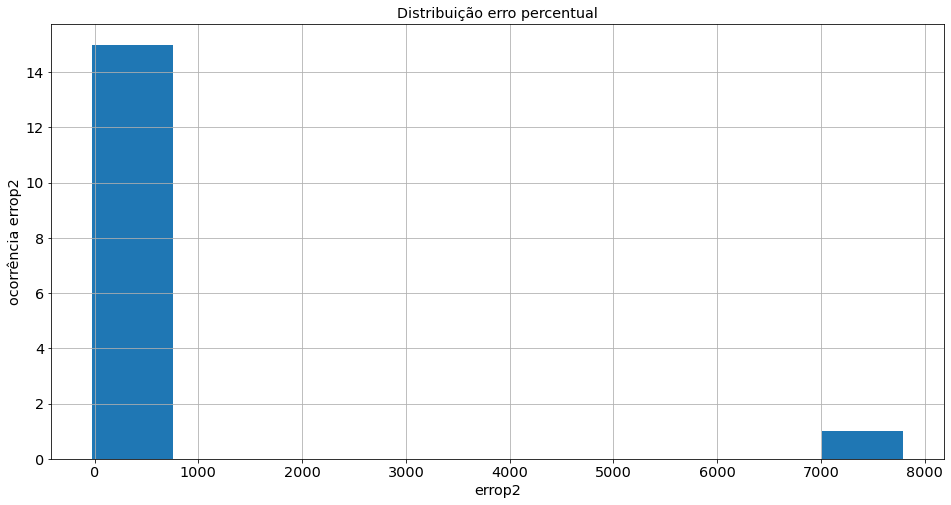

In [124]:
errop2.hist()
plt.title("Distribuição erro percentual")
plt.xlabel("errop2")
plt.ylabel("ocorrência errop2")
plt.show()

### Adaptative Boosting

In [125]:
print(random_search_ada.best_estimator_)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.15, loss='linear', n_estimators=40,
                  random_

In [154]:
m_ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.15, loss='linear', n_estimators=50,
                  random_state=None)

In [155]:
m_ada.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.15, loss='linear', n_estimators=50,
                  random_

In [156]:
y_ada = m_ada.predict(X_test)

In [157]:
mse_ada = round(mean_squared_error(y_test, y_ada),3)
print (mse_ada)

0.61


In [158]:
errop2= (y_test - y_ada)*100/y_test
# em porcentagem

In [159]:
# novo erro: modelo simples, com a média do conjunto treino
mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_ada = mse_ada/mse_m
print(round(mse_m,3), round(mse_ada,3))
print(round(r_ada,3))

0.62 0.61
0.984


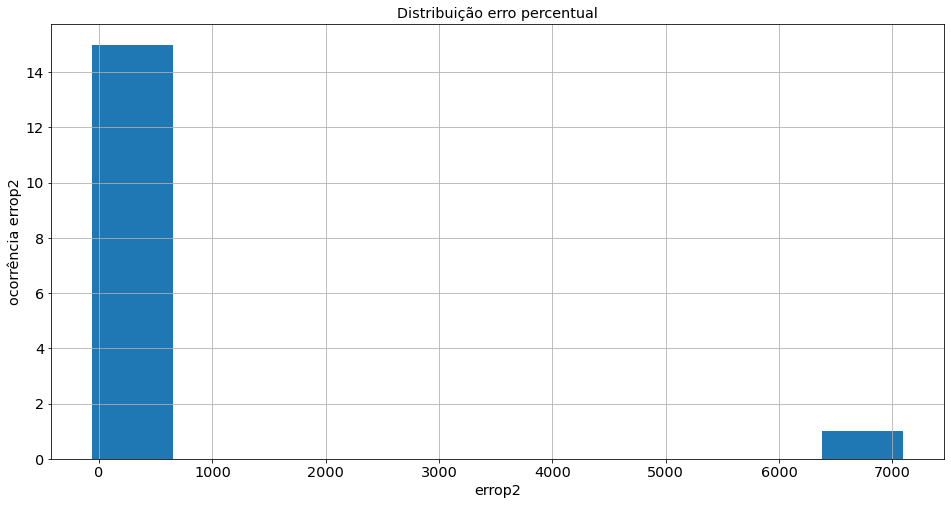

In [160]:
errop2.hist()
plt.title("Distribuição erro percentual")
plt.xlabel("errop2")
plt.ylabel("ocorrência errop2")
plt.show()

In [161]:
models=['Random_Forest','GradientBoost','LightGBM','XGBoost_1','AdaBoost']
mse=[mse_rf,mse_gbr,mse_lgb,mse_xgb_1,mse_ada]
pd.DataFrame(list(zip(mse)), columns =['Mean Square Error'], index=models)

,Mean Square Error
Random_Forest,0.574789
GradientBoost,0.601471
LightGBM,0.620000
XGBoost_1,0.351000
AdaBoost,0.610000


In [162]:
models=['Random_Forest','GradientBoost','LightGBM','XGBoost_1','AdaBoost']
r=[r_rf,r_gbr,r_lgb,r_xgb_1,r_ada]
pd.DataFrame(list(zip(r)), columns =['Razão_modelo_simples'], index=models)

,Razão_modelo_simples
Random_Forest,0.927037
GradientBoost,0.970071
LightGBM,0.999955
XGBoost_1,0.566103
AdaBoost,0.983826
